# Sentiment Polarity for Movie Reviews

In this notebook you will find:

- Some comments on the design choices and results
- Data preprocessing
- Feature extraction
- Model implementation
- Hyperparameter exploration
- Model performance evaluation

## Some comments

### On design choices:

**Data processing:** The files are appended in two separate lists, which can be beneficial as it's easier to keep track of the files, yet at the same time detrimental: if it were the case of many categories, e.g. brands or musical bands, "glueing" together lists would not be an optimal solution. Regarding tokenization, Instead of applying nltk libraries, a naive tokenizer was used, which may have had an effect on the models ability to learn. 

**Data splitting:** The data split method used in the notebook does not randomize the data set. This results in training set always being at the front and test set at the back of the list. However, it does account for equal representation of negative versus positive reviews. 
    


### On the results:

**Decision boundary:** Such words as "unfortunately, boring, worst" carry negative weights, whereas "perfect, best, memorable" are associated with positive weights. Some interesting mentions are "ridiculous" and "hilarious" associated with negative and positive connotations, respectively, even though the differentiation of the connotations could be troublesome in some contexts. In addition, are punctuation marks, which are associated with negative reviews: in order to have cleaner output, good practices dictate the removal of punctuation marks, yet it may indicate the tendency to use punctuation marks in order to emphasise disapproval. Some unexpected results include the comparative "better" as negative, yet it may be explained as its use is in comparing the subject to its superior object. Some social insight about the data could also be drawn as "american" is associated with a highly positive weight.
    
**Hyperparameters:** Interestingly enough, regulariser dampening had a much bigger effect on accuracy compared to learning rate. However, loss decreases much faster when a higher learning rate is applied. No matter the hyperparameter choice, loss is very unstable for the first 40 iterations, and then decreases steadily until convergence. 

### Loading data

In [1]:
import os, re

In [2]:
def from_txt(path_name):
    all_txt_list = list()
    title_list = [title for title in os.listdir(path_name) if title.endswith('.txt')]
    for title in title_list:
        with open(os.path.join(path_name, title)) as f:
            txt_from_file = list()
            for line in f:
                line = line.strip()
                txt_from_file.append(line)
            txt_from_file = ''.join(txt_from_file)
            all_txt_list.append(txt_from_file)
    return all_txt_list

In [3]:
neg_txt = from_txt("./txt_sentoken/neg")
pos_txt = from_txt("./txt_sentoken/pos")

## Part 1: Parsing

In [4]:
import numpy as np

In [5]:
def tokenize_it(prepros_list):
    
    digits = '\d+(\.|,)(\d*|[^a-z])'
    contractions = '(n?\'\w+)'
    negated = '\w+(?=n\'t)'
    signs = '([%\$&])'
    punctuation = '[-\'\`]+|[,;:\"\'()]' #order is important
    abbrevs = '([A-Z]([a-z]{0,3}|[A-Z]\.)\.)+'
    combos = '(\w+(-\w+)+)'
    words = '\w+'
    end = '[\.\?!\"]'
    
    tokenized_lists = list()
    tokens = list()
    for some in prepros_list:
        token_list = list()
        for token in re.findall(
            f'({contractions}|{negated}|{combos}|{digits}|{signs}|{punctuation}|{abbrevs}|{words}|{end})',
            some):
            token_list.append(token[0])
            tokens.append(token[0])
        tokenized_lists.append(token_list), tokens
    return tokenized_lists

In [6]:
neg_rev_lists = tokenize_it(neg_txt)
pos_rev_lists = tokenize_it(pos_txt)

### Splitting data

In [7]:
# in this case they are the same lenght but may be different in other cases

split_80_n = int(len(neg_rev_lists)*0.8)
split_80_p = int(len(pos_rev_lists)*0.8)

# for training
raw_neg = neg_rev_lists[:split_80_n]
raw_pos = pos_rev_lists[:split_80_p]
X_raw = raw_neg+raw_pos

# for testing
X_raw_test = neg_rev_lists[split_80_n:] + pos_rev_lists[split_80_p:]

### Creating y axis

In [8]:
y_neg = np.full((int(len(X_raw)/2)), -1, dtype=int)
y_pos = np.full((int(len(X_raw)/2)), 1, dtype=int)
y = np.append(y_neg, y_pos)
y_test_neg = np.full((int(len(X_raw_test)/2)), -1, dtype=int)
y_test_pos = np.full((int(len(X_raw_test)/2)), 1, dtype=int)
y_test = np.append(y_test_neg, y_test_pos)
y.shape, y_test.shape

((1600,), (400,))

In [9]:
len(X_raw)

1600

### Checking assumptions nr. 1

In [10]:
# X_temp is only for checking assumptions, I use list of lists of tokens instead.
X_temp = list()
for review in X_raw:
    for token in review:
        tokens_str = ''.join(token)
    X_temp.append(tokens_str)

In [11]:
assert np.all([isinstance(x, str) for x in X_temp])
assert len(X_raw) == y.shape[0]
assert len(np.unique(y))==2
assert y.min() == -1
assert y.max() == 1

## Part 2: Feature extraction

In [12]:
def get_dictionaries(data):
    frequency_dictionary = dict()
    tokens = list()
    keys = list()
    index_dictionary = dict()
    for token_list in data:
        for token in token_list:
            tokens.append(token)
            if token in frequency_dictionary:
                frequency_dictionary[token] += 1
            else:
                frequency_dictionary[token] = 1
                # keys is a separate list,
                # because dict.keys() is dict_keys type, needed a list
                keys.append(token) 
    sorted_vocabulary = sorted(keys)
    for i, token in enumerate(sorted_vocabulary):
        index_dictionary[token] = i
    return frequency_dictionary, keys, sorted_vocabulary, tokens, index_dictionary

In [13]:
freq, vocab, ord_vocab, tokens, index_dict = get_dictionaries(X_raw)
print('Documents:', len(X_raw), 'Unique words:', len(vocab), 'Corpus size:', len(tokens))

Documents: 1600 Unique words: 41986 Corpus size: 1224570


In [14]:
def to_bag_of_words(doc_list, ordered_vocabulary, indexed_dictionary):
    bow_matrix = np.zeros((len(doc_list), len(ordered_vocabulary)), dtype=int)
    for index, doc in enumerate(doc_list):
        for tok in doc:
            if tok in indexed_dictionary:
                bow_matrix[index, indexed_dictionary[tok]] = int(1)
    return bow_matrix

In [15]:
X = to_bag_of_words(X_raw, ord_vocab, index_dict)

### Checking assumptions nr. 2

In [16]:
lut = dict()
for i, word in enumerate(ord_vocab):
    lut[word] = i

for word in ['dolphin', 'the', 'good', 'humongous']:
    if word in vocab:
        print("'%s' is represented as feature dimension %i" %(word, lut[word]))
    else:
        print("'%s' is not in the vocabulary" % word)
        
print(ord_vocab[2000:2010])
print(X[:10, 2000:2010])
for w in ['dolphin', 'theeeeee', 'coffee']:
  print("'%s' in words: %s" % (w, w in vocab))

'dolphin' is represented as feature dimension 11150
'the' is represented as feature dimension 37344
'good' is represented as feature dimension 15948
'humongous' is not in the vocabulary
['alberto', 'albertson', 'albino', 'albinos', 'album', 'albums', 'alc', 'alcatraz', 'alchemy', 'alcohol']
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
'dolphin' in words: True
'theeeeee' in words: False
'coffee' in words: True


In [17]:
# This cell is just for debugging
index = 900
fail_checker_dict = dict()
for token in X_raw[index]:
    if token in fail_checker_dict:
        fail_checker_dict[token] += 1
    else:
        fail_checker_dict[token] = 1

if len(fail_checker_dict) == np.sum(X[index]):
    print('Coast clear, probably')
else:
    print('Something went wrong.')

Coast clear, probably


In [22]:
# pseudo_input = np.ones(len(X))
# pseudo_input = pseudo_input.T
# X = np.insert(X, 0, pseudo_input, axis=1)
# X.shape, pseudo_input.shape

## Part 3: Model

In [30]:
import matplotlib.pyplot as plt

In [31]:
class model:
    def __init__(self, learning_rate=0.01, reg_dampening=0.01, iterations=250, verbose=False, visualise=False):
        self.learning_rate = learning_rate
        self.reg_dampening = reg_dampening
        self.iterations = iterations
        self.verbose = verbose
        self.visualise = visualise
    
    def fit(self, X, y):
        def theta_generator(X, theta):
            return X.T.dot(theta).ravel()
        
        def hinge_loss(X, y, theta):
            hinge_loss = 0
            for i in range(len(X)): 
                hinge_loss += max(0, 1-y[i]*theta_generator(X[i], theta)) 
            return (self.reg_dampening/2)*(np.linalg.norm(theta)**2) + hinge_loss
       
        def update_gradient(X, y, theta):
            sigma = np.zeros(X.shape[1])
            for i in range(X.shape[0]):
                if y[i]*theta_generator(X[i], theta) >= 1:
                    continue
                else:
                    sigma += (-y[i]*X[i])
            return self.reg_dampening*theta + sigma
        
        init_theta = np.random.randint(0, 1, (X.shape[1]))
        theta_history = [init_theta]
        loss_history = [hinge_loss(X, y, init_theta)[0]]
        converged = False
        i = 0
        while not converged and i < self.iterations:
            # creating new theta
            self.theta = theta_history[i] - self.learning_rate*update_gradient(X, y, theta_history[i])
            # calculating loss
            loss = hinge_loss(X, y, self.theta)
            theta_history.append(self.theta)
            loss_history.append(loss)
            convergence = loss_history[i] - loss
            i += 1
            if self.verbose:
                print("%20s \t %.3f  \t%f" % (i, loss, convergence))
            if convergence < 0.01:
                if loss == min(loss_history):
                    converged = True
        if i != self.iterations:
            print('Convergence achieved on iteration:', i)
        if self.visualise:
            plt.plot(loss_history)
            plt.ylabel('Loss')
            plt.show()
        return self.theta 
    
    def predict(self, X):
        return np.sign(X.T.dot(self.theta).ravel())
    
    def score(self, X, y):
        correct, incorrect = 0, 0
        for i in range(X.shape[0]):
            y_hat = self.predict(X[i,:])
            if y_hat == y[i]:
                correct += 1
            else:
                incorrect += 1
        return round(correct/X.shape[0], 4)

In [32]:
# Ignoring matplotlib Deprecation warnings
import warnings
warnings.filterwarnings("ignore")

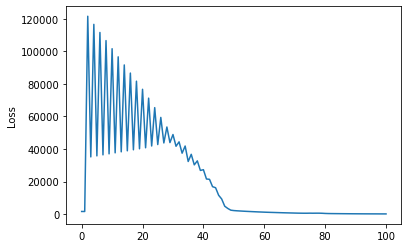

array([-0.04187763, -4.24982339, -1.04365207, ...,  0.26993377,
       -0.16497311,  0.06598456])

In [33]:
alpha = model(learning_rate=0.003, reg_dampening=0.001, iterations=100, visualise=True)
alpha.fit(X, y)

In [34]:
print('Accuracy achieved by model compared to train set:', alpha.score(X, y)*100, '%')

Accuracy achieved by model compared to train set: 99.5 %


### Checking assumptions nr. 3

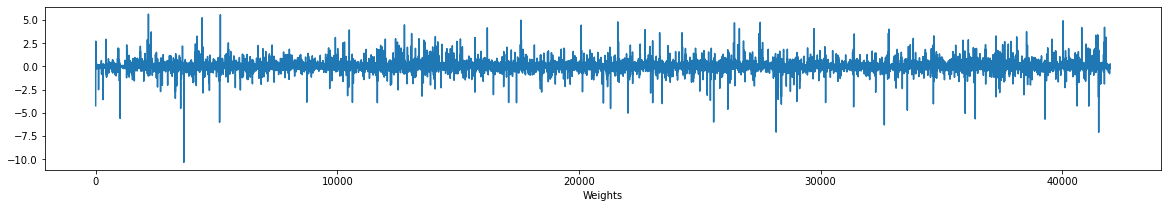

In [35]:
import matplotlib.pyplot as plt
 
plt.figure(figsize=(20, 3))
plt.plot(alpha.theta[1:])
plt.xlabel("Value")
plt.xlabel("Weights")
plt.show()

In [49]:
assert (len(alpha.theta)-1) == len(ord_vocab)
idx = np.argsort(np.abs(alpha.theta[1:]))
print("                Word   Weight  Occurences")
for i in idx[-100:]:
    print("%20s   %.3f\t%i " % (ord_vocab[i], alpha.theta[i+1], freq[ord_vocab[i]]))

                Word   Weight  Occurences
                save   -2.789	230 
              strong   2.819	213 
              family   2.828	515 
               there   -2.834	3025 
                 him   2.843	2131 
              subtle   2.861	103 
              better   -2.864	719 
              allows   2.876	80 
            material   -2.876	197 
                 've   2.924	679 
               until   2.936	345 
           effective   2.939	139 
                 fun   2.957	453 
              ending   2.981	332 
           extremely   2.984	205 
              simple   3.017	221 
               guess   -3.053	184 
               tries   -3.059	295 
                  no   -3.113	1908 
               gives   3.113	416 
          definitely   3.113	141 
                your   3.146	707 
            dialogue   -3.170	427 
                town   3.182	311 
               films   3.209	1218 
               fails   -3.212	133 
               world   3.257	829 
              begins   3.260

In [50]:
pos_weight, neg_weight, neutral = 0, 0, 0
for i in alpha.theta:
    if i > 0:
        pos_weight += 1
    else:
        neg_weight +=1
    
print("Positive wieghts: %i \nNegative weights: %i" % (pos_weight, neg_weight))

Positive wieghts: 21857 
Negative weights: 20130


## Part 4: exploring hyperparamaters

In [38]:
def create_grid():
    grid = list()
    hyperparameters = {'Learning rate': np.exp(np.linspace(np.log(0.0001), np.log(3), 10)),
                       'Reg. dampening': np.exp(np.linspace(np.log(0.0001), np.log(3), 10))}
    for ler_rate in hyperparameters['Learning rate']:
        for reg_damp in hyperparameters['Reg. dampening']:
            grid.append((ler_rate, reg_damp))
    return grid

In [39]:
import random

def set_hyperparameters(X, y, grid, iterations, trials=10):
    acc_history = dict()
    parameters_history = dict()
    model_history = dict()
    max_acc, max_index = 0, 0
    print("Learning rate:\tReg.dampening:\tAccuracy:")
    for trial in range(trials):
        learning_rate = grid[random.randint(1, len(grid))][0]
        reguliser_dampening = grid[random.randint(1, len(grid))][1]
        model_history[trial] = model(iterations=iterations,reg_dampening=reguliser_dampening, learning_rate=learning_rate)
        model_history[trial].fit(X, y)
        acc_history[trial] = model_history[trial].score(X, y)*100
        parameters_history[trial] = (learning_rate, reguliser_dampening)
        print("%.5f\t\t%.5f\t\t%.1f%%" % (learning_rate, reguliser_dampening, acc_history[trial]))
        if acc_history[trial] > max_acc:
            max_acc = acc_history[trial]
            max_index = trial
    print('Best hyperparamters (learning rate and reg. dampening):', round(parameters_history[max_index][0], 4), round(parameters_history[max_index][1], 4))
    print('Best accuracy:',acc_history[max_index])
    return model_history

In [40]:
grid = create_grid()
hypers = set_hyperparameters(X, y, grid, iterations=50, trials=25)

Learning rate:	Reg.dampening:	Accuracy:
0.30353		0.00099		92.9%
0.30353		0.09655		50.8%
0.30353		0.00977		81.3%
0.09655		0.09655		59.6%
0.00010		0.00031		70.4%
0.09655		0.95425		50.0%
0.95425		3.00000		50.0%
0.03071		0.00010		92.8%
0.30353		0.00099		92.9%
0.03071		0.00099		92.9%
0.00010		0.09655		70.4%
0.00099		0.00010		90.4%
0.00031		0.00099		75.4%
0.00010		0.30353		70.4%
0.00010		0.00031		70.4%
0.00031		0.00977		75.4%
0.03071		0.00010		92.8%
0.00031		0.00031		75.4%
0.00977		0.00977		92.8%
0.03071		0.03071		91.8%
0.00099		3.00000		74.2%
0.00099		0.00311		90.4%
0.09655		0.00031		92.9%
0.00099		0.30353		90.1%
3.00000		0.00010		92.9%
Best hyperparamters (learning rate and reg. dampening): 0.3035 0.001
Best accuracy: 92.86999999999999


Convergence achieved on iteration: 155


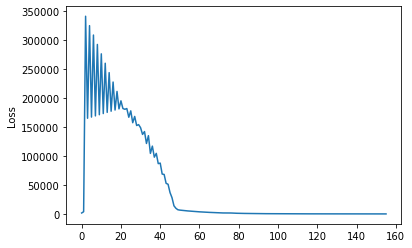

array([ -0.29297895, -13.59786004,  -2.94024718, ...,   0.88895136,
        -0.51775409,   0.21491207])

In [41]:
final_model = model(iterations=300, learning_rate=0.00977, reg_dampening=0.00010, visualise=True)
final_model.fit(X, y)

In [42]:
print('Accuracy achieved by model compared to train set:', final_model.score(X, y)*100, '%')

Accuracy achieved by model compared to train set: 100.0 %


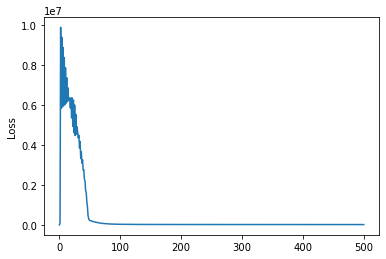

array([  -7.79524023, -367.98850356,  -79.094034  , ...,   23.90046779,
        -14.02888477,    5.78412355])

In [43]:
alpha_2 = model(iterations=500, learning_rate=0.30353, reg_dampening=0.00099, visualise=True)
alpha_2.fit(X, y)

In [44]:
print("Accuracy of alpha_2:", str(alpha_2.score(X, y)*100)+'%')

Accuracy of alpha_2: 100.0%


### Checking model performance on test set

In [45]:
X_test = to_bag_of_words(X_raw_test, ord_vocab, index_dict)
X_test = np.insert(X_test, 0, np.zeros(len(X_test)), axis=1)
X_test.shape

(400, 41987)

In [46]:
baseline = model(iterations=1, learning_rate=10, reg_dampening=10)
baseline.fit(X, y)

array([   0., -950., -170., ...,   50.,  -10.,   10.])

In [47]:
print('Test accuracy:', str(alpha.score(X_test, y_test)*100) +'% \twith model: alpha')
print('Test accuracy:', str(alpha_2.score(X_test, y_test)*100) +'% \twith model: alpha_2')
print('Test accuracy:', str(final_model.score(X_test, y_test)*100) +'% \twith model: final_model')
print('Test accuracy:', str(baseline.score(X_test, y_test)*100) +'% \twith model: baseline')

Test accuracy: 85.25% 	with model: alpha
Test accuracy: 85.5% 	with model: alpha_2
Test accuracy: 85.5% 	with model: final_model
Test accuracy: 64.5% 	with model: baseline
